In [28]:
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.optimize as opt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from copy import deepcopy
from utils import boxplot_significance, extract_data, violinplot_significance, splitedviolinplot_significance # per importare dento al codice (utils.py) le def (in questo caso boxplot_significance e extract_data)

In [29]:
# qui ogni volta va chiamata la cartella corretta del file di Log

json_files = [pos_json for pos_json in os.listdir("Log") if pos_json.endswith('.json')]
data = []
for index, js in enumerate(json_files):
    with open(os.path.join('./Log/', js)) as json_file:
        json_text = json.load(json_file)
        data.append(json_text)

print(json_files)
print(len(json_files))

['logfile_20250411_114956.json', 'logfile_20250403_122328.json', 'logfile_20250403_102854.json', 'logfile_20250328_111350.json', 'logfile_20250402_154441.json', 'logfile_20250321_122554.json', 'logfile_20250319_094340.json', 'logfile_20250327_161307.json', 'logfile_20250404_175224.json', 'logfile_20250319_120923.json', 'logfile_20250402_101522.json', 'logfile_20250327_103947.json', 'logfile_20250411_170105.json', 'logfile_20250320_113159.json', 'logfile_20250416_093830.json', 'logfile_20250402_172451.json', 'logfile_20250321_155138.json', 'logfile_20250404_155009.json', 'logfile_20250411_152611.json', 'logfile_20250319_151412.json', 'logfile_20250320_154557.json', 'logfile_20250320_132144.json', 'logfile_20250410_152658.json', 'logfile_20250327_175815.json', 'logfile_20250328_155903.json', 'logfile_20250410_172416.json', 'logfile_20250320_182801.json', 'logfile_20250327_123422.json', 'logfile_20250416_174530.json', 'logfile_20250326_133256.json', 'logfile_20250326_103619.json', 'logfil

In [30]:
names = []
for idx in range(len(data)):
    log = data[idx]
    names.append(log["user"]["nickname"])
    
new_order = [names.index(name) for name in sorted(names)]

new_data = []
for idx in new_order:
    new_data.append(data[idx])
data = deepcopy(new_data)

MI VADO A PRENDERE I PUNTI FATTI DAI SOGGETTI PER TRIAL

In [31]:
import pandas as pd

results = []
nicknames = {}
counter = 0

for log in data:
    name = log["user"]["nickname"]
    if name not in nicknames:
        counter += 1
        nicknames[name] = counter
    assigned_number = nicknames[name]
    
    trials = log.get("trials", [])
    valid_trials = [t for t in trials if t.get("trialCode") and not t["trialCode"].startswith("tutorial")]
    
    previous_outcome = None
    
    for i, trial in enumerate(valid_trials[-60:]):  # Consider only the last 60 trials (excluding tutorials)
        trial_number = trial.get("trialNumber")
        trial_code = trial.get("trialCode")
        events = trial.get("events", [])
        
        if events:
            last_event = events[-1]  # Get the last event of the trial
            outcome = last_event.get("outcome", [])  # Extract outcome
            outcome_value = outcome[1] if len(outcome) > 1 else None  # Get the value associated with key 1
        else:
            outcome_value = None
        
        if i == 0:  # If it's the first trial, PointsPerTrial is equal to OutcomeValue
            points_per_trial = outcome_value
        else:
            points_per_trial = (outcome_value or 0) - (previous_outcome or 0) if previous_outcome is not None else None
        
        previous_outcome = outcome_value
        
        # Compute Trial Halfs Position, starting from trial number 5
        trial_halfs_position = (trial_number - 5) // 5 + 1 if trial_number >= 5 else None
        
        results.append({
            "Subject": name,
            "SubjectCode": assigned_number,
            "TrialNumber": trial_number,
            "Trial": trial_code,
            "OutcomeValue": outcome_value,
            "PointsPerTrial": points_per_trial,
            "TrialHalfsPosition": trial_halfs_position
        })

# Create DataFrame and save results
df = pd.DataFrame(results)

print(df.head(10))



  Subject  SubjectCode  TrialNumber     Trial  OutcomeValue  PointsPerTrial  \
0  Annnag            1            5  trial_A9           309             309   
1  Annnag            1            6  trial_A8           320              11   
2  Annnag            1            7  trial_A5           625             305   
3  Annnag            1            8  trial_A0          1130             505   
4  Annnag            1            9  trial_A7          1635             505   
5  Annnag            1           10  trial_A3          1944             309   
6  Annnag            1           11  trial_A4          2550             606   
7  Annnag            1           12  trial_A2          3257             707   
8  Annnag            1           13  trial_A1          3465             208   
9  Annnag            1           14  trial_A6          3575             110   

   TrialHalfsPosition  
0                   1  
1                   1  
2                   1  
3                   1  
4         

In [32]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf



# Fit Linear Mixed Model with Subject as a random intercept
model = smf.mixedlm("PointsPerTrial ~ TrialHalfsPosition", df, groups=df["Subject"])
result = model.fit()

# Print summary of the model
print(result.summary())


              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  PointsPerTrial
No. Observations:    2040     Method:              REML          
No. Groups:          34       Scale:               37894.4452    
Min. group size:     60       Log-Likelihood:      -13671.2119   
Max. group size:     60       Converged:           Yes           
Mean group size:     60.0                                        
-----------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           443.938   12.858 34.526 0.000 418.737 469.140
TrialHalfsPosition    7.213    1.249  5.777 0.000   4.766   9.660
Group Var          2750.406    4.312                             



MI VADO A PRENDERE I PUNTI FATTI DAI SOGGETTI PER BLOCCO E PER HALFBLOCK E LI METTO IN EXCEL. 
Inoltre voglio prendere la somma dei punti fatti dai soggetti ("TotalPoints") e anche quanto migliorano, o peggiorano, tra prima e seconda metà di ogni blocco ("average_second_first_difference"). Questo ultimo dato l'ho calcolato facendo per ogni soggetto la differenza tra seconda e prima metà di ogni blocco e poi la media per soggetto tra questi valori.

In [33]:
import pandas as pd

def compute_block_sums(x):
    block_sums = []
    half_block_sums = []
    
    for i in range(0, 60, 10):
        full_block = x["PointsPerTrial"].iloc[i:i+10].sum()
        first_half = x["PointsPerTrial"].iloc[i:i+5].sum()
        second_half = x["PointsPerTrial"].iloc[i+5:i+10].sum()
        
        block_sums.append(full_block)
        half_block_sums.extend([first_half, second_half])
    
    return block_sums + half_block_sums

# Group by subject and apply function
block_and_half_sums = (
    df.groupby("Subject")
    .apply(compute_block_sums)
    .apply(pd.Series)
)

# Rename columns
block_columns = [f"Points_{i+1}Block" for i in range(6)]
half_block_columns = [f"Points_{i//2+1}Block_{'1Half' if i%2==0 else '2Half'}" for i in range(12)]
block_and_half_sums.columns = block_columns + half_block_columns

# Reset index to make 'Subject' a column
block_and_half_sums.reset_index(inplace=True)

# ➕ Calcola il totale dei punti (solo i blocchi interi)
block_and_half_sums["TotalPoints"] = block_and_half_sums[block_columns].sum(axis=1)

# ✅ Calculate per-block half differences: 2nd half - 1st half
differences = [
    block_and_half_sums[f"Points_{i+1}Block_2Half"] - block_and_half_sums[f"Points_{i+1}Block_1Half"]
    for i in range(6)
]

# Stack the differences and take the row-wise average
average_second_first_difference = pd.concat(differences, axis=1).mean(axis=1)

# Add to the main DataFrame
block_and_half_sums["average_second_first_difference"] = average_second_first_difference

# Sum the difference
sum_second_first_difference = pd.concat(differences, axis=1).sum(axis=1)

# Add to the main DataFrame
block_and_half_sums["sum_second_first_difference"] = sum_second_first_difference

# Save to Excel and CSV
excel_file = "block_and_half_sums.xlsx"
csv_file = "block_and_half_sums.csv"

block_and_half_sums.to_excel(excel_file, index=False)
block_and_half_sums.to_csv(csv_file, index=False)

print(f"Data saved to {excel_file} and {csv_file}")




Data saved to block_and_half_sums.xlsx and block_and_half_sums.csv


Voglio fare i grafici ora

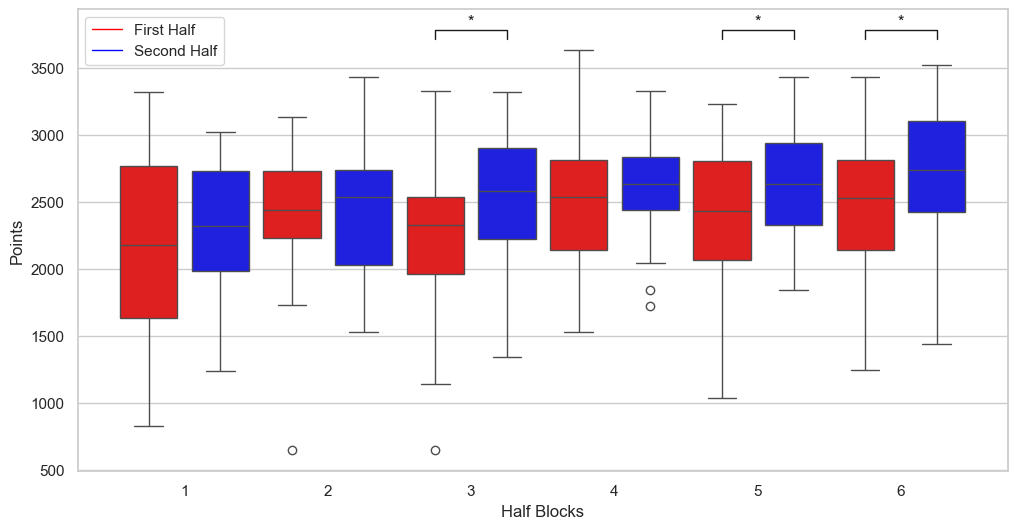

Significant Comparison: Points_3Block_1Half vs Points_3Block_2Half | p-value: 0.0329
Significant Comparison: Points_5Block_1Half vs Points_5Block_2Half | p-value: 0.0226
Significant Comparison: Points_6Block_1Half vs Points_6Block_2Half | p-value: 0.0451


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Seleziona solo le colonne delle metà dei blocchi
half_block_columns = [f"Points_{i//2+1}Block_{'1Half' if i%2==0 else '2Half'}" for i in range(12)]
data = block_and_half_sums[half_block_columns]

# Creazione del boxplot con colori personalizzati
plt.figure(figsize=(12, 6))

# Colori per le "first half" e "second half" dei blocchi
colors = ['red' if i % 2 == 0 else 'blue' for i in range(12)]

sns.boxplot(data=data, palette=colors)

# Update xticks to start from 1.5 and label only the first 6 blocks, equally distributed
plt.xticks(ticks=[i + 0.5 for i in range(0, 12, 2)], labels=["1", "2", "3", "4", "5", "6"])

plt.ylabel("Points")
plt.xlabel("Half Blocks")

# Confronti limitati tra la prima e seconda metà di ciascun blocco
comparisons = [(f"Points_{i+1}Block_1Half", f"Points_{i+1}Block_2Half") for i in range(6)]

# Lista per memorizzare i confronti significativi e i loro p-values
significant_combinations = []

# Per ogni coppia, faccio il test di significatività e aggiungo le barre sopra i boxplot
ax = plt.gca()  # get current axis
bottom, top = ax.get_ylim()
yrange = top - bottom 

for i, (col1, col2) in enumerate(comparisons):
    data1 = data[col1]
    data2 = data[col2]
    
    # Esegui il t-test
    _, p = stats.ttest_ind(data1, data2, alternative='two-sided') 

    # Se significativo, aggiungi la linea di significatività sopra il boxplot
    if p < 0.05:
        # Memorizza il confronto significativo con il p-value
        significant_combinations.append((col1, col2, p))

        # Trova gli indici per le due colonne
        x1 = half_block_columns.index(col1)  # Indice della "first half"
        x2 = half_block_columns.index(col2)  # Indice della "second half"

        level = len(comparisons) - i  # Per spostare la linea orizzontale verso l'alto

        # Posizione della barra sopra i boxplot
        bar_height = top
        bar_tips = bar_height - (yrange * 0.02)

        # Linea orizzontale tra i box
        plt.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')

        # Simboli di significatività
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'

        # Testo (asterisco) sopra la linea
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

# Aggiungi la legenda
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='red', lw=1, label='First Half'),
    Line2D([0], [0], color='blue', lw=1, label='Second Half')
]
plt.legend(handles=legend_elements)

# Visualizza il grafico finale
plt.show()

# Stampa i confronti significativi e i p-value
for col1, col2, p in significant_combinations:
    print(f"Significant Comparison: {col1} vs {col2} | p-value: {p:.4f}")


In [43]:
# Calcola i delta (prima metà - seconda metà) per ciascun blocco
deltas = []

for i in range(6):
    col1 = f"Points_{i+1}Block_1Half"
    col2 = f"Points_{i+1}Block_2Half"
    delta = data[col1] - data[col2]  # Serie di differenze riga per riga
    deltas.append(delta)

# Concatena tutti i delta in un'unica Serie
all_deltas = pd.concat(deltas, axis=0)

# Esegui un t-test su questi delta (test se media delle differenze ≠ 0)
t_stat, p_value = stats.ttest_1samp(all_deltas, popmean=0)

# Mostra risultati
print("\n=== Test sulla differenza media complessiva (delta) tra prime e seconde metà dei blocchi ===")
print(f"Media delta: {all_deltas.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ Differenza significativa tra le prime e seconde metà dei blocchi.")
else:
    print("→ Nessuna differenza significativa tra le prime e seconde metà.")



=== Test sulla differenza media complessiva (delta) tra prime e seconde metà dei blocchi ===
Media delta: -188.3431
T-statistic: -3.7866
P-value: 0.0002
→ Differenza significativa tra le prime e seconde metà dei blocchi.


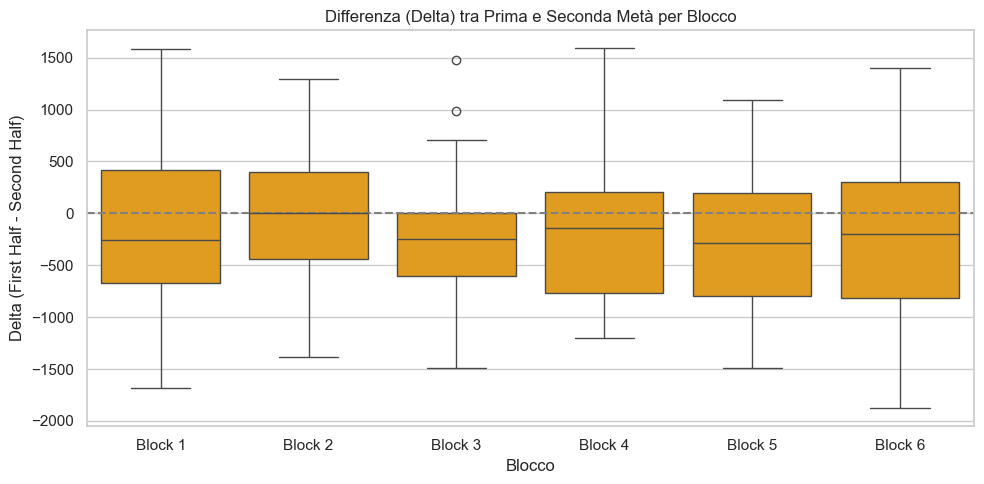

In [44]:
# Import necessario nel caso non sia già stato fatto
import matplotlib.pyplot as plt

# Crea un nuovo DataFrame per i delta
delta_df = pd.DataFrame({f"Block {i+1}": deltas[i] for i in range(6)})

# Boxplot dei delta
plt.figure(figsize=(10, 5))
sns.boxplot(data=delta_df, color="orange")

plt.axhline(0, color='gray', linestyle='--')  # Linea di riferimento per il delta zero
plt.title("Differenza (Delta) tra Prima e Seconda Metà per Blocco")
plt.ylabel("Delta (First Half - Second Half)")
plt.xlabel("Blocco")
plt.tight_layout()
plt.show()


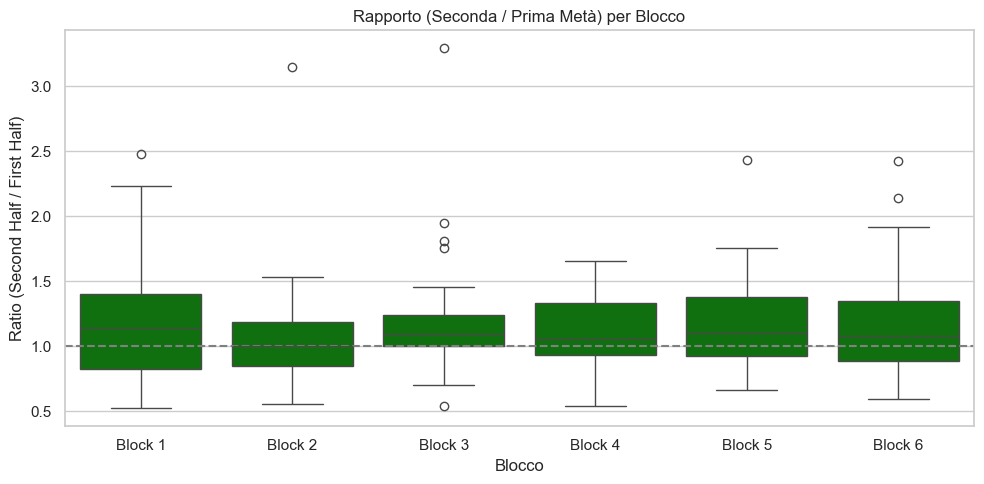

In [45]:
# Calcola le ratio (seconda metà / prima metà) per ciascun blocco
ratios = []

for i in range(6):
    col1 = f"Points_{i+1}Block_1Half"
    col2 = f"Points_{i+1}Block_2Half"
    
    # Aggiungi una piccola costante per evitare divisioni per zero, se necessario
    ratio = data[col2] / (data[col1] + 1e-8)
    ratios.append(ratio)

# Crea un DataFrame con i ratio
ratio_df = pd.DataFrame({f"Block {i+1}": ratios[i] for i in range(6)})

# Plot del boxplot dei ratio
plt.figure(figsize=(10, 5))
sns.boxplot(data=ratio_df, color='green')

plt.axhline(1, color='gray', linestyle='--')  # Linea di riferimento (nessun cambiamento)
plt.title("Rapporto (Seconda / Prima Metà) per Blocco")
plt.ylabel("Ratio (Second Half / First Half)")
plt.xlabel("Blocco")
plt.tight_layout()
plt.show()


Pearson correlation coefficient (First Half R): 0.7012
P-value (First Half): 0.1206
Pearson correlation coefficient (Second Half R): 0.9859
P-value (Second Half): 0.0003


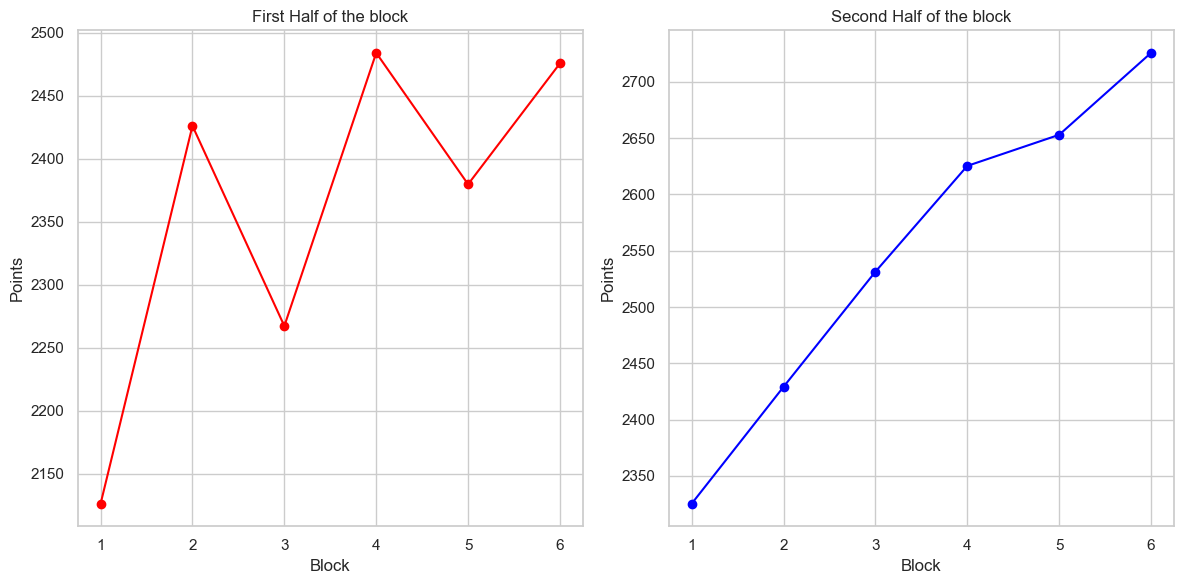

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Numero di partecipanti/soggetti
num_subjects = len(block_and_half_sums)

# Colonne per ciascun blocco divise per metà
first_half_cols = [f"Points_{i+1}Block_1Half" for i in range(6)]
second_half_cols = [f"Points_{i+1}Block_2Half" for i in range(6)]

# Estrai i valori per ogni blocco per tutti i soggetti
first_half_values = [
    block_and_half_sums[col].values for col in first_half_cols
]  # Lista di array: ogni array = valori di un blocco per tutti i soggetti

second_half_values = [
    block_and_half_sums[col].values for col in second_half_cols
]

# Calcola la media dei punti per blocco
mean_first_half = np.mean(first_half_values, axis=1)
mean_second_half = np.mean(second_half_values, axis=1)

# Calcola la correlazione di Pearson (per trend)
x = np.arange(1, 7)  # Blocchi da 1 a 6
r_first_half, p_first_half = pearsonr(x, mean_first_half)
r_second_half, p_second_half = pearsonr(x, mean_second_half)

# Stampa risultati Pearson
print(f"Pearson correlation coefficient (First Half R): {r_first_half:.4f}")
print(f"P-value (First Half): {p_first_half:.4f}")
print(f"Pearson correlation coefficient (Second Half R): {r_second_half:.4f}")
print(f"P-value (Second Half): {p_second_half:.4f}")

# Creazione grafico
plt.figure(figsize=(12, 6))

# Subplot - prima metà
plt.subplot(1, 2, 1)
plt.plot(x, mean_first_half, marker='o', linestyle='-', color='red')
plt.title("First Half of the block")
plt.xlabel("Block")
plt.ylabel("Points")
plt.grid(True)

# Subplot - seconda metà
plt.subplot(1, 2, 2)
plt.plot(x, mean_second_half, marker='o', linestyle='-', color='blue')
plt.title("Second Half of the block")
plt.xlabel("Block")
plt.ylabel("Points")
plt.grid(True)

# Mostra grafico
plt.tight_layout()
plt.show()


Pearson correlation coefficient (First Half R): 0.7012
P-value (First Half): 0.1206
Pearson correlation coefficient (Second Half R): 0.9859
P-value (Second Half): 0.0003


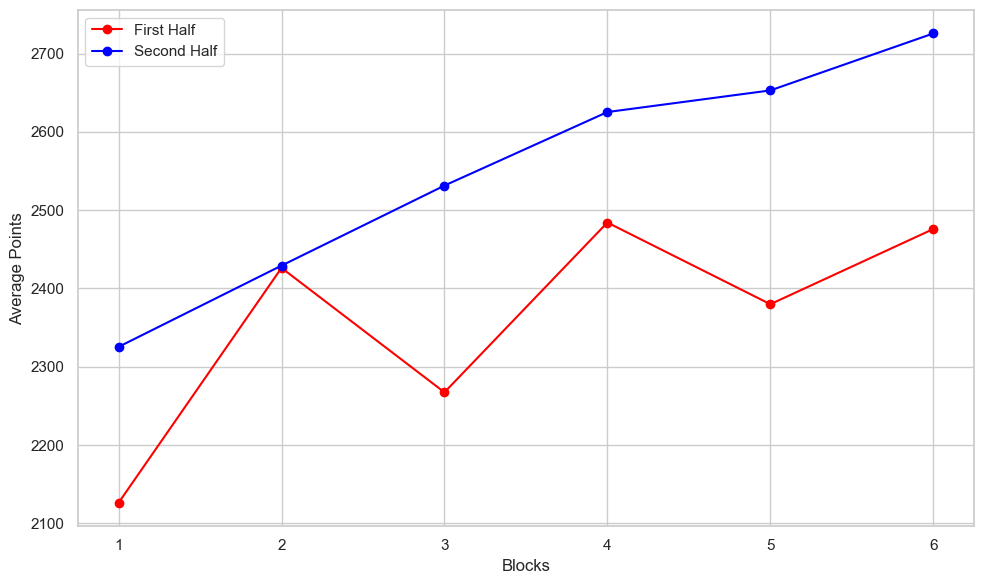

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Numero di soggetti
num_subjects = len(block_and_half_sums)

# Colonne per ciascun blocco divise per metà
first_half_cols = [f"Points_{i+1}Block_1Half" for i in range(6)]
second_half_cols = [f"Points_{i+1}Block_2Half" for i in range(6)]

# Estrazione dei valori per blocco
first_half_values = [block_and_half_sums[col].values for col in first_half_cols]
second_half_values = [block_and_half_sums[col].values for col in second_half_cols]

# Calcola la media per ciascun blocco
mean_first_half = np.mean(first_half_values, axis=1)
mean_second_half = np.mean(second_half_values, axis=1)

# Calcola la Pearson correlation
x = np.arange(1, 7)
r_first_half, p_first_half = pearsonr(x, mean_first_half)
r_second_half, p_second_half = pearsonr(x, mean_second_half)

# Stampa risultati Pearson
print(f"Pearson correlation coefficient (First Half R): {r_first_half:.4f}")
print(f"P-value (First Half): {p_first_half:.4f}")
print(f"Pearson correlation coefficient (Second Half R): {r_second_half:.4f}")
print(f"P-value (Second Half): {p_second_half:.4f}")

# Crea la figura
plt.figure(figsize=(10, 6))

# Plot sia per la prima che per la seconda metà
plt.plot(x, mean_first_half, marker='o', linestyle='-', color='red', label='First Half')
plt.plot(x, mean_second_half, marker='o', linestyle='-', color='blue', label='Second Half')


plt.xlabel("Blocks")
plt.ylabel("Average Points")
plt.xticks(x)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Ratio Second Half / First Half: [1.09366182 1.00120012 1.11644982 1.05680661 1.11473769 1.10089215]


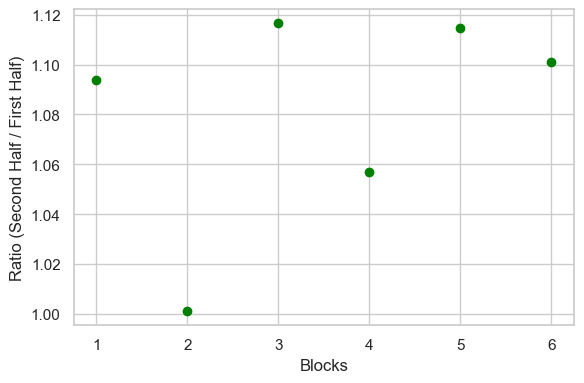

In [52]:
# Calcola la ratio tra la seconda metà e la prima metà
ratio = mean_second_half / mean_first_half

# Stampa la ratio
print("Ratio Second Half / First Half:", ratio)

# Crea un grafico della ratio
plt.figure(figsize=(6, 4))
plt.scatter(x, ratio, color='green', label='Second Half / First Half Ratio')

plt.xlabel("Blocks")
plt.ylabel("Ratio (Second Half / First Half)")
plt.xticks(x)
plt.grid(True)

plt.tight_layout()
plt.show()


In [46]:
from scipy import stats

# Calcolo della ratio (media seconda metà / media prima metà) per ciascun blocco
ratios = mean_second_half / (mean_first_half + 1e-8)  # evita divisione per zero

# Calcolo della media delle ratio
mean_ratio = np.mean(ratios)

# Test: la media delle ratio è significativamente diversa da 1?
t_stat, p_value = stats.ttest_1samp(ratios, popmean=1)

# Stampa dei risultati
print(f"\n=== Analisi del Rapporto (Second Half / First Half) ===")
print(f"Ratio per blocco: {[round(r, 4) for r in ratios]}")
print(f"Media dei ratio: {mean_ratio:.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ La seconda metà è significativamente diversa dalla prima metà (ratio ≠ 1).")
else:
    print("→ Nessuna differenza significativa nel rapporto tra le due metà.")



=== Analisi del Rapporto (Second Half / First Half) ===
Ratio per blocco: [1.0937, 1.0012, 1.1164, 1.0568, 1.1147, 1.1009]
Media dei ratio: 1.0806
T-statistic: 4.4375
P-value: 0.0068
→ La seconda metà è significativamente diversa dalla prima metà (ratio ≠ 1).



=== Analisi del Rapporto (Second Half / First Half) ===
Ratio per blocco: [1.0937, 1.0012, 1.1164, 1.0568, 1.1147, 1.1009]
Media dei ratio: 1.0806
T-statistic: 4.4375
P-value (T-test): 0.0068
R-squared: 0.1451
P-value (Regression): 0.4563
→ La seconda metà è significativamente diversa dalla prima metà (ratio ≠ 1).


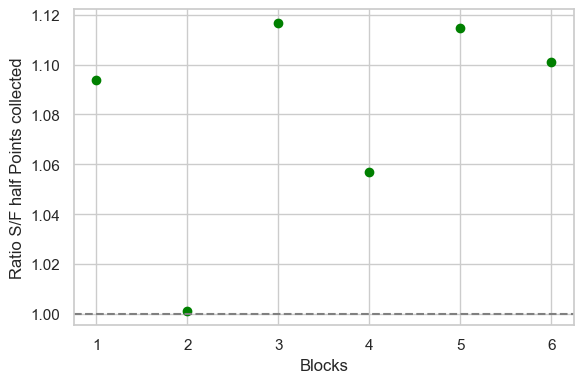

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calcolo della ratio (seconda metà / prima metà) per ciascun blocco
ratios = mean_second_half / (mean_first_half + 1e-8)  # evitare divisione per zero
x = np.arange(1, 7)

# Test: la media delle ratio è significativamente diversa da 1?
t_stat, p_value_ttest = stats.ttest_1samp(ratios, popmean=1)
mean_ratio = np.mean(ratios)

# Calcolare la regressione lineare per calcolare R^2 e p-value
slope, intercept, r_value, p_value_regression, std_err = stats.linregress(x, ratios)
r_squared = r_value**2  # Calcolare R^2

# Stampa dei risultati
print(f"\n=== Analisi del Rapporto (Second Half / First Half) ===")
print(f"Ratio per blocco: {[round(r, 4) for r in ratios]}")
print(f"Media dei ratio: {mean_ratio:.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value (T-test): {p_value_ttest:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value (Regression): {p_value_regression:.4f}")

if p_value_ttest < 0.05:
    print("→ La seconda metà è significativamente diversa dalla prima metà (ratio ≠ 1).")
else:
    print("→ Nessuna differenza significativa nel rapporto tra le due metà.")

# Plot delle ratio (solo punti, senza linee)
plt.figure(figsize=(6, 4))
plt.scatter(x, ratios, color='green', label='Second Half / First Half Ratio')
plt.axhline(1, color='gray', linestyle='--')  # Riferimento: ratio = 1
plt.xlabel("Blocks")
plt.ylabel("Ratio S/F half Points collected")
plt.xticks(x)
plt.grid(True)
plt.tight_layout()
plt.show()
